# Experiment: Piecewise-linear approximation of VNF-PPs (Analysis)

Try to represent VNF-PPs as piece-wise linear functions.
The fitting is done using the [pwlf Python library](https://pypi.org/project/pwlf/).

Cite PWLF:

```latex
@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}
```

## Segment number optimization

* Bayesian Optimization using [GPyOpt](https://sheffieldml.github.io/GPyOpt/)

```
@Misc{gpyopt2016,
  author =   {The GPyOpt authors},
  title =    {GPyOpt: A Bayesian Optimization framework in Python},
  howpublished = {\url{http://github.com/SheffieldML/GPyOpt}},
  year = {2016}
}
```

In [17]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import random
random.seed(12121)
np.random.seed(12121)
import pwlf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics as em

## Data Management
Load and clean the data sets to be easily used.

### Load data sets

In [18]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/smallFlows.pcap", "0")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/bigFlows.pcap", "1")
    _to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "1")
    _replace(df, "ruleset", "./start.sh big_ruleset", "2")
    _replace(df, "ruleset", "./start.sh", "0")
    _to_num(df, "ruleset")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "1")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "1")
    _to_num(df, "req_size")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json", "0")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json", "1")
    _replace(df, "req_type", "malaria publish -s 10 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "2")
    _replace(df, "req_type", "malaria publish -s 10000 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "3")
    _to_num(df, "req_type")
    
df_sec01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec01/data/csv_experiments.csv")
df_sec02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec02/data/csv_experiments.csv")
df_sec03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec03/data/csv_experiments.csv")
df_web01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web01/data/csv_experiments.csv")
df_web02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web02/data/csv_experiments.csv")
df_web03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web03/data/csv_experiments.csv")
df_iot01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot01/data/csv_experiments.csv")
df_iot02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot02/data/csv_experiments.csv")

# do renaming and selection
map_sec01 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__suricata_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__suricata_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec02 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort2.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort2.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort2.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__snort_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__snort_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__snort_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__snort_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec03 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort3.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort3.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort3.0.1__mem_max": "memory",
    #"metric__vnf0.vdu01.0__snort3_total_allow": "ids_allow",
    "metric__vnf0.vdu01.0__snort3_total_analyzed": "ids_pkts",
    "metric__vnf0.vdu01.0__snort3_total_received": "ids_recv",
    #"metric__vnf0.vdu01.0__snort3_total_outstanding": "ids_outstanding",
    "metric__vnf0.vdu01.0__snort3_total_dropped": "ids_drop",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web01 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-nginx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-nginx.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web02 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-haproxy.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-haproxy.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web03 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.px-squid.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.px-squid.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot01 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-mosquitto.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-mosquitto.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot02 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-emqx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-emqx.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
    

}

# add additional data
df_sec01["vnf"] = "suricata"
df_sec02["vnf"] = "snort2"
df_sec03["vnf"] = "snort3"
df_web01["vnf"] = "nginx"
df_web02["vnf"] = "haproxy"
df_web03["vnf"] = "squid"
df_iot01["vnf"] = "mosquitto"
df_iot02["vnf"] = "emqx"


# cleanup data sets
dfs_raw = [df_sec01, df_sec02, df_sec03, df_web01, df_web02, df_web03, df_iot01, df_iot02]
map_list = [map_sec01, map_sec02, map_sec03, map_web01, map_web02, map_web03, map_iot01, map_iot02]
dfs = list()  # clean data frames

for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)

dfs[0].head()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,flow_size,ruleset,cpu_bw,memory,ids_bytes,ids_pkts,ids_drop,if_rx_bytes
0,0,1,0.1,256,23300110.0,41300.0,708299.0,2.195881e+10
1,0,1,0.1,256,27921373.5,47600.0,707497.5,2.193566e+10
2,0,1,0.1,256,23931763.0,41370.0,712914.0,2.172597e+10
3,0,1,0.1,256,26639147.0,45220.0,704784.0,2.159297e+10
4,0,1,0.1,256,23087775.0,40460.0,708648.0,2.155866e+10


### Polish data

In [19]:
#df = dfs[0].copy()
#df = df[(df["flow_size"]==0) & (df["ruleset"]==2) & (df["memory"]==256)]
#df = df.groupby("cpu_bw").mean()
#df.head()
#dfs[1][dfs[1]["ids_pkts"].isnull()]

dfs[0][["cpu_bw", "ids_bytes"]].to_numpy()

array([[1.00000000e-01, 2.33001100e+07],
       [1.00000000e-01, 2.79213735e+07],
       [1.00000000e-01, 2.39317630e+07],
       ...,
       [1.00000000e+00, 9.84725415e+07],
       [1.00000000e+00, 9.78965090e+07],
       [1.00000000e+00, 1.00549273e+08]])

## PWLF Prototype

More advanced PWLF implementation to be used with generic data sets.

In [20]:
class MyPWLF(object):
    """
    Wrapper around PWLF to also fit functions with only one
    segment by using a trick that creates a first segment that is
    virtually 0.
    """
    def __init__(self, data, x_col, y_col, degree=1):
        # ensure we work on fresh data
        data = data.copy()
        # ensure that we drop the NaN from the data
        data.dropna(subset=[x_col, y_col], inplace=True)
        # get the data
        self.xin = np.array(data[x_col])
        self.yin = np.array(data[y_col])
        assert(len(self.xin) == len(self.yin))
        # PWLF Model
        self.pwlf_obj = pwlf.PiecewiseLinFit(self.xin, self.yin, degree=degree)       
        
    def fit(self, nseg):
        if nseg < 2:
            # Workaround: fit(1) does not work, so we do it by specifing the breakpoints manually
            x0 = np.array([min(self.xin), max(self.xin)])
            self.pwlf_obj.fit_with_breaks(x0)
            return x0
        # do normal PWLF fit
        return self.pwlf_obj.fit(nseg)
    
    def predict(self, x):
        return self.pwlf_obj.predict(x)

def plot_pwlf(mpf, x, y, ax=None, x_bpoints=None, points=True, pointargs=None, lineargs=None):
    assert(ax is not None)
    if pointargs is None:
        pointargs = {}
    if lineargs is None:
        lineargs = {}
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = mpf.predict(xHat)
    
    # calc additional error metrics    
    mpf.err_mse = em.mean_squared_error(y, mpf.predict(x))
    mpf.err_mae = em.mean_absolute_error(y, mpf.predict(x))
    mpf.err_r2 = em.r2_score(y, mpf.predict(x))
    mpf.err_evs = em.explained_variance_score(y, mpf.predict(x))
    
    # plot data points
    if points:
        ax.plot(x, y, 'o', color="grey", fillstyle='none', **pointargs)
    # plot breakpoints
    if x_bpoints is not None:
        y_bpoints = mpf.predict(x_bpoints)
        label = "break pt." if points else None
        ax.plot(x_bpoints, y_bpoints, 'o', color="firebrick", markersize=7, label=label)
    # plot fit line
    ax.plot(xHat, yHat, **lineargs)
    return x, y, mpf    

## Analysis

In [21]:
def get_lstyle(label):
    if "(opt)" in label:
        # special case
        return {"color": "firebrick", "ls": 'solid', "lw": 2.0} 
    # normal case
    styles = [
        ('densely dashed',        (0, (5, 1))),
        ('dotted', 'dotted'),
        ('dashed', 'dashed'),
        ('dashdot', 'dashdot'),
        ('densely dotted',        (0, (1, 1))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
    ]
    # colors
    l = int(label.replace("(opt)", "").strip()) - 1
    return {"color": "tab:blue", "ls": styles[l][1], "lw": 2.0}    

In [22]:
def select(data, sel_dict):
    """
    Select subset of data from DF.
    """
    for k, v in sel_dict.items():
        data = data[data[k]==v]
    return data

In [23]:
def analyse_fits(data, x_col, y_col, name="unnamed", x_label="x-axis", y_label="y-axis"):
    """
    - Shows fit with multiple lines (1-n segments + opt. segment (solid, bold)) in a single plot
    - Creates multiple plots for different degrees
    Returns DF with error metrics.
    """
    res_dicts = list()
    # iterate over different degrees (one plot per degree)
    for degree in [0, 1, 2]:
        print("PWLF degree={}".format(degree))
        # create a PWLF object and get raw input data
        mpf = MyPWLF(data, x_col, y_col, degree=degree)
        (x, y) = (mpf.xin, mpf.yin)
        
        # define number of segments to test
        segments = {"1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
                
        # create figure
        matplotlib.rcParams.update({'font.size': 22})
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        # analyse for different no. segments
        for label, nseg in segments.items():
            lineargs = {"label": "nseg={}".format(label)}
            lineargs.update(get_lstyle(label))
            
            # fit PWLF to the data
            breaks = mpf.fit(nseg)
            
            # plot
            plot_pwlf(mpf, x, y, ax=ax,
                      x_bpoints=breaks, # plot breakpoints
                      points=(nseg==1),  # ensure points are only plotted once
                      pointargs={"label": "data", "markersize": 12},
                      lineargs=lineargs,
                      
                     )
            print("PWLF fit: label={}, nseg={}, MAE={}, MSE={}, EVS={}, R^2={}".format(label, nseg, mpf.err_mae, mpf.err_mse, mpf.err_evs, mpf.err_r2))
            res_dicts.append({"name": name, "label": label, "nseg": nseg, "degree": degree, "mae": mpf.err_mae, "mse": mpf.err_mse, "evs": mpf.err_evs, "r2": mpf.err_r2})
        # finalize plot
        ax.set_ylim(min(0.0, min(y)), np.max(y)*1.1)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(fancybox=False, shadow=False, fontsize="small", ncol=2)
        plt.savefig("plots/analysis_fits_deg-{}_{}_{}_{}.pdf".format(degree, x_col, y_col, name), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
    # return DF with error metrics for further plots
    return pd.DataFrame(res_dicts)
        
        

In [24]:
def analyse_errors(data):
    """
    Bar plots with error values.
    Input: DF that was returmed by analyse_fit()
    """
    x_col = "degree"
    y_cols = ["mae", "mse", "evs", "r2"]
    y_labels = {"mae": "MAE", "mse": "MSE", "evs": "EVS", "r2": "$R^2$"}
    hue = "nseg"
    matplotlib.rcParams.update({'font.size': 22})
    name = list(set(list(data["name"])))[0]
    
    for y_col in y_cols:
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue, data=data, palette=sns.color_palette("Reds_d"), linewidth=3, saturation=.9, edgecolor=(1,1,1))
        if y_col == "mse":
            ax.set_yscale('log')
        y_lim_min = 0.0
        if y_col == "r2" or y_col == "evs":
            y_lim_min = data[y_col].min() - 0.1
        if y_col != "mse":
            ax.set_ylim(y_lim_min, data[y_col].max() * 1.1)
        
        ax.set_xlabel("Degree")
        ax.set_ylabel(y_labels[y_col])
        ax.legend(fancybox=False, shadow=False, fontsize="small", ncol=2, title="Segments", loc="upper right")
        plt.savefig("plots/error-{}-{}.pdf".format(name, y_col), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

### Fit Analysis of Data Sets

PWLF degree=0
PWLF fit: label=1, nseg=1, MAE=48207.509375, MSE=3513412826.7698436, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=28770.821624999997, MSE=1107407074.269427, EVS=0.6848058771142036, R^2=0.6848058771142037
PWLF fit: label=3, nseg=3, MAE=17104.771949999995, MSE=398763339.1805542, EVS=0.8865025663530782, R^2=0.8865025663530782
PWLF fit: label=4, nseg=4, MAE=13634.645375, MSE=214469134.54098433, EVS=0.938957035476482, R^2=0.9389570354764821
PWLF fit: label=5, nseg=5, MAE=10906.46558333333, MSE=150890890.9939792, EVS=0.9570529002899141, R^2=0.9570529002899141
PWLF fit: label=6, nseg=6, MAE=8197.561583333334, MSE=107761486.54285416, EVS=0.9693285441090828, R^2=0.9693285441090828


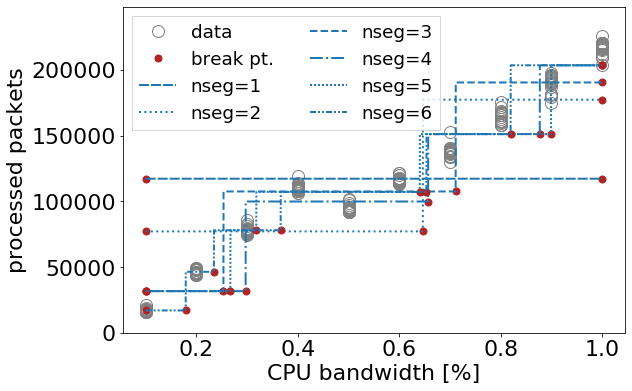

PWLF degree=1
PWLF fit: label=1, nseg=1, MAE=9820.227831818178, MSE=134549859.76325107, EVS=0.9617039424635581, R^2=0.9617039424635581
PWLF fit: label=2, nseg=2, MAE=8374.829109628745, MSE=117082707.97173357, EVS=0.9666755050588869, R^2=0.9666755050588869
PWLF fit: label=3, nseg=3, MAE=2700.3182800560235, MSE=14552032.510867896, EVS=0.9958581489769744, R^2=0.9958581489769744
PWLF fit: label=4, nseg=4, MAE=2573.2201391790836, MSE=13704489.566782312, EVS=0.9960993796509299, R^2=0.9960993796509299
PWLF fit: label=5, nseg=5, MAE=2535.083623238475, MSE=13488901.867072934, EVS=0.9961607409854326, R^2=0.9961607409854326
PWLF fit: label=6, nseg=6, MAE=2537.4033822633737, MSE=13483735.353156304, EVS=0.9961622114969185, R^2=0.9961622114969185


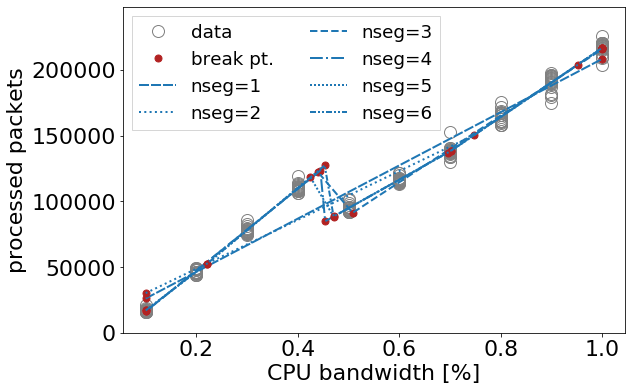

PWLF degree=2
PWLF fit: label=1, nseg=1, MAE=9602.084921212108, MSE=133088534.89049351, EVS=0.9621198699234976, R^2=0.9621198699234976
PWLF fit: label=2, nseg=2, MAE=5175.3720211668615, MSE=41645731.289076746, EVS=0.9881466444900058, R^2=0.9881466444900058
PWLF fit: label=3, nseg=3, MAE=2575.258053034885, MSE=13689672.968319772, EVS=0.9961035968036509, R^2=0.9961035968036509
PWLF fit: label=4, nseg=4, MAE=2538.3912591057947, MSE=13482017.200562568, EVS=0.9961627005235939, R^2=0.9961627005235939
PWLF fit: label=5, nseg=5, MAE=2551.5158911204767, MSE=13486349.669286378, EVS=0.9961615356350343, R^2=0.9961614674010041
PWLF fit: label=6, nseg=6, MAE=2538.3912499999024, MSE=13482017.200562501, EVS=0.9961627005235939, R^2=0.9961627005235939


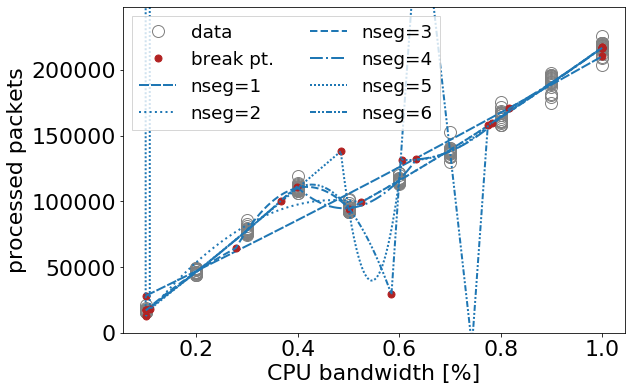

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,48207.509375,3.513413e+09,ds-sec01,1,0.000000
1,0,0.684806,2,28770.821625,1.107407e+09,ds-sec01,2,0.684806
2,0,0.886503,3,17104.771950,3.987633e+08,ds-sec01,3,0.886503
3,0,0.938957,4,13634.645375,2.144691e+08,ds-sec01,4,0.938957
4,0,0.957053,5,10906.465583,1.508909e+08,ds-sec01,5,0.957053
5,0,0.969329,6,8197.561583,1.077615e+08,ds-sec01,6,0.969329
6,1,0.961704,1,9820.227832,1.345499e+08,ds-sec01,1,0.961704
7,1,0.966676,2,8374.829110,1.170827e+08,ds-sec01,2,0.966676
8,1,0.995858,3,2700.318280,1.455203e+07,ds-sec01,3,0.995858
9,1,0.996099,4,2573.220139,1.370449e+07,ds-sec01,4,0.996099


In [25]:
d = select(dfs[0].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec01", x_label="CPU bandwidth [%]", y_label="processed packets")
df_err

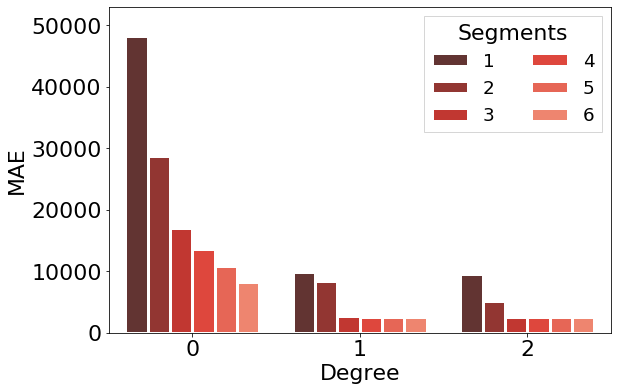

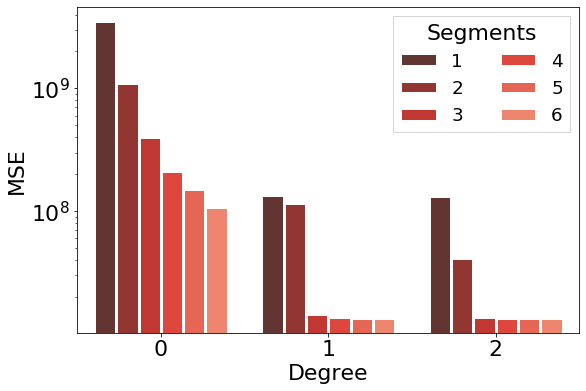

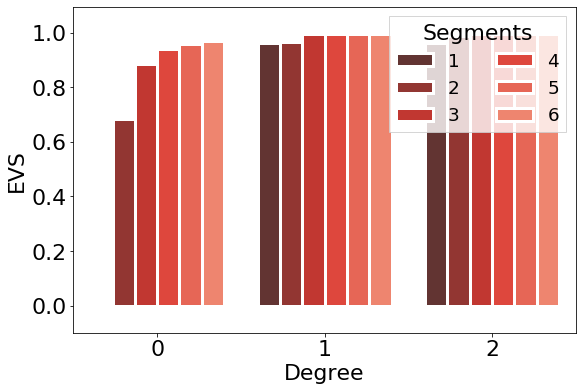

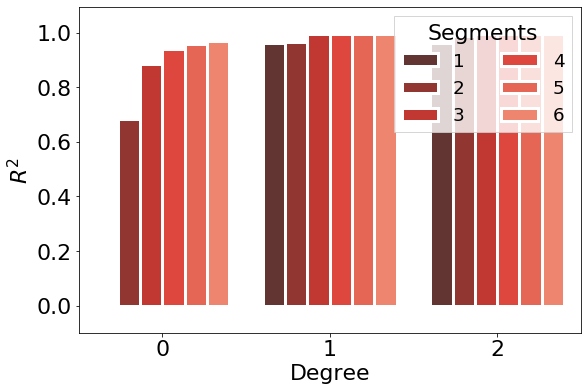

In [26]:
analyse_errors(df_err)

PWLF degree=0
PWLF fit: label=1, nseg=1, MAE=10554.207777777778, MSE=153247728.39765432, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=5490.287222222221, MSE=40690660.03465278, EVS=0.7344778910584125, R^2=0.7344778910584125
PWLF fit: label=3, nseg=3, MAE=3502.04037037037, MSE=17886539.786435187, EVS=0.8832834915502149, R^2=0.8832834915502149
PWLF fit: label=4, nseg=4, MAE=2858.742916666666, MSE=10188031.618854167, EVS=0.9335191997598961, R^2=0.9335191997598961
PWLF fit: label=5, nseg=5, MAE=2197.4306944444447, MSE=5941596.023715277, EVS=0.9612288150314519, R^2=0.9612288150314519
PWLF fit: label=6, nseg=6, MAE=1630.7912499999989, MSE=3883645.459375, EVS=0.9746577290248797, R^2=0.9746577290248797


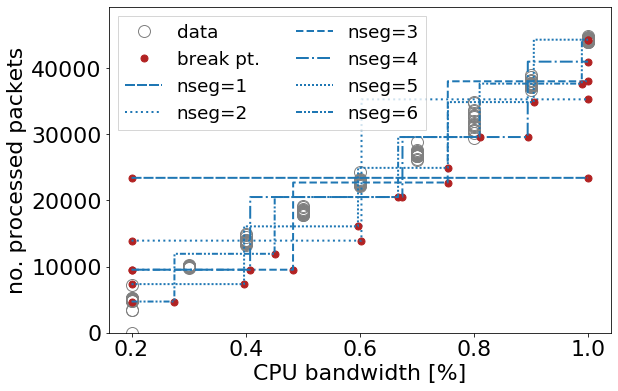

PWLF degree=1
PWLF fit: label=1, nseg=1, MAE=909.7511759259249, MSE=1297328.7810698322, EVS=0.9915344338566412, R^2=0.9915344338566412
PWLF fit: label=2, nseg=2, MAE=484.3659326229886, MSE=607950.877410714, EVS=0.9960328881624061, R^2=0.9960328881624061
PWLF fit: label=3, nseg=3, MAE=481.52755043958393, MSE=583846.3385953455, EVS=0.9961901794910764, R^2=0.9961901794910764
PWLF fit: label=4, nseg=4, MAE=451.5243382316022, MSE=561512.1322430846, EVS=0.9963359187237931, R^2=0.9963359187237931
PWLF fit: label=5, nseg=5, MAE=429.4306327702811, MSE=551616.76781174, EVS=0.9964004897587756, R^2=0.9964004897587756
PWLF fit: label=6, nseg=6, MAE=432.0006018557937, MSE=563289.1692215513, EVS=0.9963247576756362, R^2=0.9963243228783144


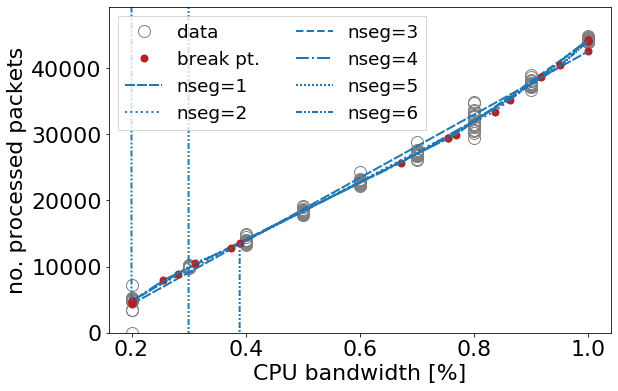

PWLF degree=2
PWLF fit: label=1, nseg=1, MAE=624.1085600048083, MSE=795544.4233605694, EVS=0.9948087685756996, R^2=0.9948087685756996
PWLF fit: label=2, nseg=2, MAE=479.21169279099496, MSE=585936.5442612218, EVS=0.9961765401002173, R^2=0.9961765401002173
PWLF fit: label=3, nseg=3, MAE=432.1827237300376, MSE=552397.5660555579, EVS=0.9963953947518088, R^2=0.9963953947518088
PWLF fit: label=4, nseg=4, MAE=429.5772222023376, MSE=551271.5658333334, EVS=0.9964027423336229, R^2=0.9964027423336229
PWLF fit: label=5, nseg=5, MAE=429.5772222222248, MSE=551271.5658333333, EVS=0.9964027423336229, R^2=0.9964027423336229
PWLF fit: label=6, nseg=6, MAE=429.57722222222685, MSE=551271.5658333333, EVS=0.9964027423336229, R^2=0.9964027423336229


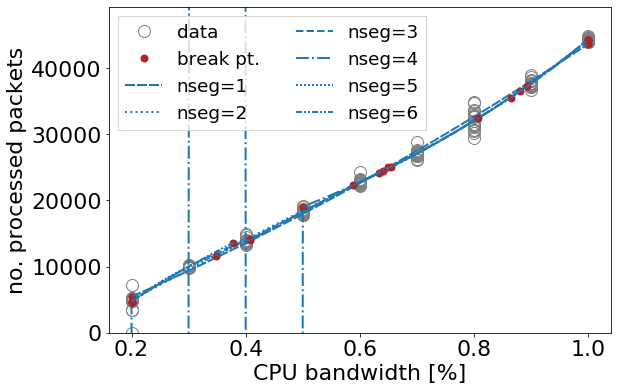

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,10554.207778,1.532477e+08,ds-sec02,1,0.000000
1,0,0.734478,2,5490.287222,4.069066e+07,ds-sec02,2,0.734478
2,0,0.883283,3,3502.040370,1.788654e+07,ds-sec02,3,0.883283
3,0,0.933519,4,2858.742917,1.018803e+07,ds-sec02,4,0.933519
4,0,0.961229,5,2197.430694,5.941596e+06,ds-sec02,5,0.961229
5,0,0.974658,6,1630.791250,3.883645e+06,ds-sec02,6,0.974658
6,1,0.991534,1,909.751176,1.297329e+06,ds-sec02,1,0.991534
7,1,0.996033,2,484.365933,6.079509e+05,ds-sec02,2,0.996033
8,1,0.996190,3,481.527550,5.838463e+05,ds-sec02,3,0.996190
9,1,0.996336,4,451.524338,5.615121e+05,ds-sec02,4,0.996336


In [27]:
d = select(dfs[1].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec02", x_label="CPU bandwidth [%]", y_label="no. processed packets")
df_err

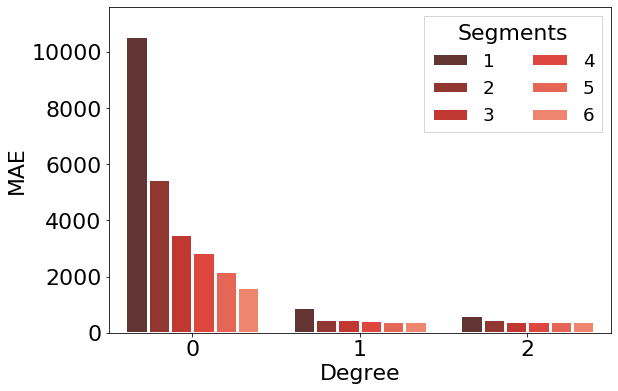

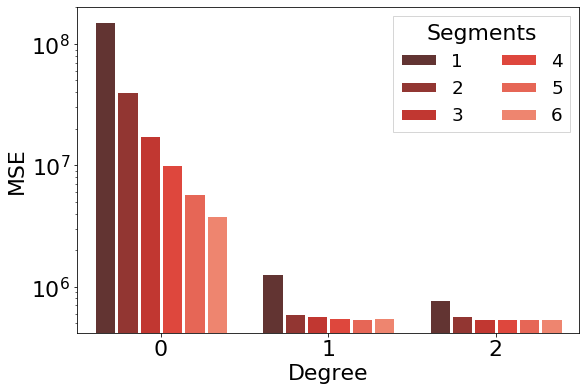

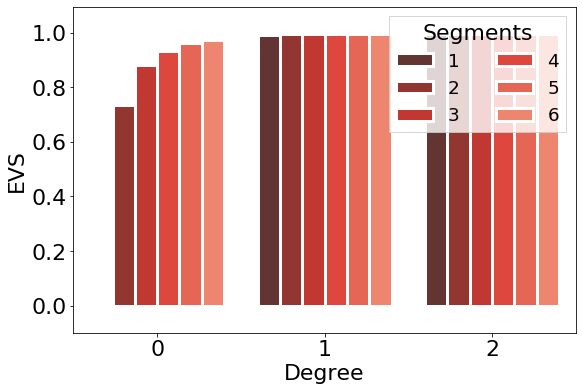

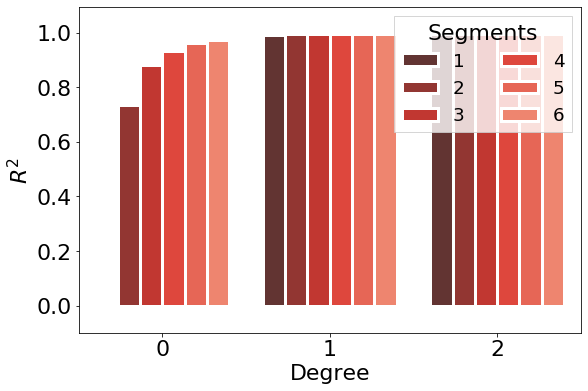

In [28]:
analyse_errors(df_err)

PWLF degree=0
PWLF fit: label=1, nseg=1, MAE=9514221.280000003, MSE=119882590359025.36, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=4619495.441100001, MSE=29362183794220.523, EVS=0.7550754975656897, R^2=0.7550754975656897
PWLF fit: label=3, nseg=3, MAE=3077654.7300000004, MSE=12993901413357.05, EVS=0.8916114393721156, R^2=0.8916114393721156
PWLF fit: label=4, nseg=4, MAE=2311076.796166668, MSE=7188349308033.367, EVS=0.9400384218717193, R^2=0.9400384218717193
PWLF fit: label=5, nseg=5, MAE=1927880.9, MSE=3760772814104.345, EVS=0.9686295332554831, R^2=0.9686295332554831
PWLF fit: label=6, nseg=6, MAE=1541162.55, MSE=2856112869179.8096, EVS=0.9761757494509729, R^2=0.9761757494509729


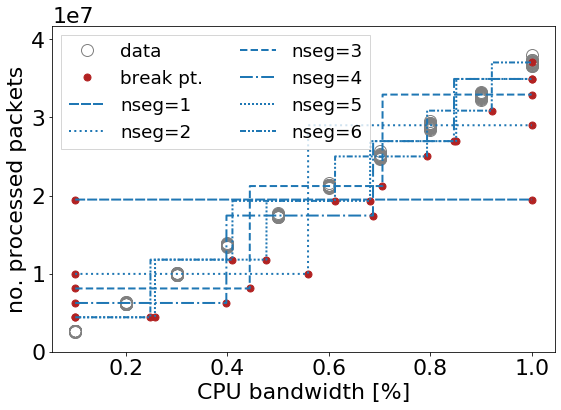

PWLF degree=1
PWLF fit: label=1, nseg=1, MAE=199698.2892272732, MSE=68777877335.94951, EVS=0.9994262896961938, R^2=0.9994262896961938
PWLF fit: label=2, nseg=2, MAE=138436.51365692483, MSE=37452225993.22123, EVS=0.999687592452907, R^2=0.999687592452907
PWLF fit: label=3, nseg=3, MAE=123929.0294623276, MSE=33944390568.791992, EVS=0.9997168530437395, R^2=0.9997168530437395
PWLF fit: label=4, nseg=4, MAE=119550.3525445636, MSE=32819775226.63375, EVS=0.9997262340167297, R^2=0.9997262340167297
PWLF fit: label=5, nseg=5, MAE=119500.71964361217, MSE=32804994568.86673, EVS=0.9997263573095091, R^2=0.9997263573095091
PWLF fit: label=6, nseg=6, MAE=119448.05833066916, MSE=32793918236.036255, EVS=0.9997264497026814, R^2=0.9997264497026814


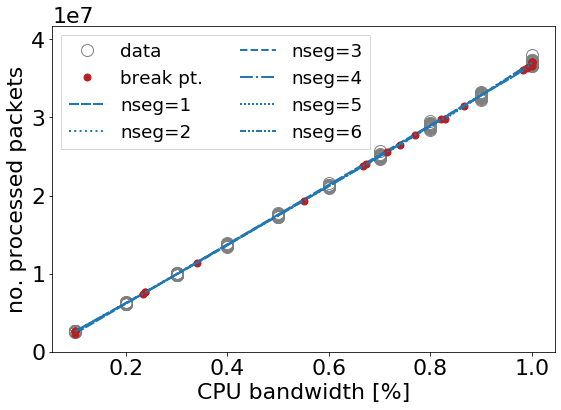

PWLF degree=2
PWLF fit: label=1, nseg=1, MAE=124841.5269924237, MSE=36203412102.282326, EVS=0.9996980094274418, R^2=0.9996980094274418
PWLF fit: label=2, nseg=2, MAE=121922.8513869046, MSE=33210439846.120373, EVS=0.999722975289851, R^2=0.999722975289851
PWLF fit: label=3, nseg=3, MAE=119390.7888232584, MSE=32851605938.04682, EVS=0.999725968501017, R^2=0.999725968501017
PWLF fit: label=4, nseg=4, MAE=119349.68212364106, MSE=32791711154.873505, EVS=0.9997264681130373, R^2=0.9997264681130373
PWLF fit: label=5, nseg=5, MAE=119368.46497104196, MSE=32791971257.894043, EVS=0.9997264661022797, R^2=0.9997264659433893
PWLF fit: label=6, nseg=6, MAE=119349.68200000614, MSE=32791711154.873497, EVS=0.9997264681130373, R^2=0.9997264681130373


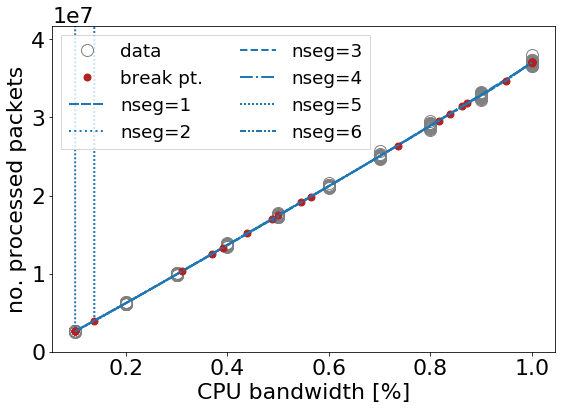

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,9.514221e+06,1.198826e+14,ds-sec03,1,0.000000
1,0,0.755075,2,4.619495e+06,2.936218e+13,ds-sec03,2,0.755075
2,0,0.891611,3,3.077655e+06,1.299390e+13,ds-sec03,3,0.891611
3,0,0.940038,4,2.311077e+06,7.188349e+12,ds-sec03,4,0.940038
4,0,0.968630,5,1.927881e+06,3.760773e+12,ds-sec03,5,0.968630
5,0,0.976176,6,1.541163e+06,2.856113e+12,ds-sec03,6,0.976176
6,1,0.999426,1,1.996983e+05,6.877788e+10,ds-sec03,1,0.999426
7,1,0.999688,2,1.384365e+05,3.745223e+10,ds-sec03,2,0.999688
8,1,0.999717,3,1.239290e+05,3.394439e+10,ds-sec03,3,0.999717
9,1,0.999726,4,1.195504e+05,3.281978e+10,ds-sec03,4,0.999726


In [29]:
d = select(dfs[2].copy(), {"flow_size": 0, "ruleset": 0, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec03", x_label="CPU bandwidth [%]", y_label="no. processed packets")
df_err

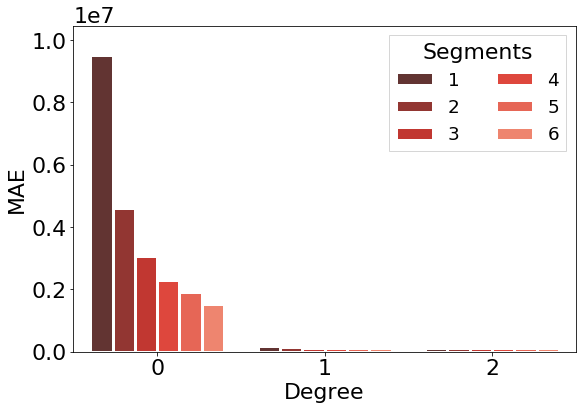

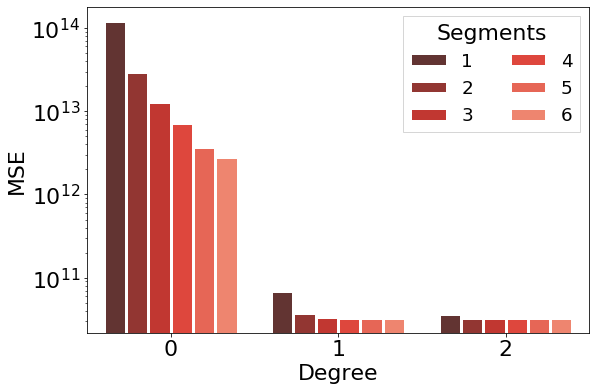

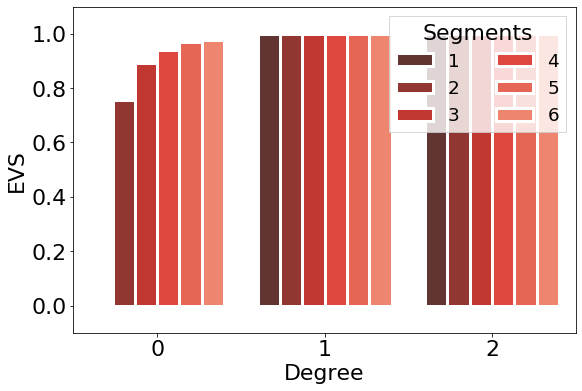

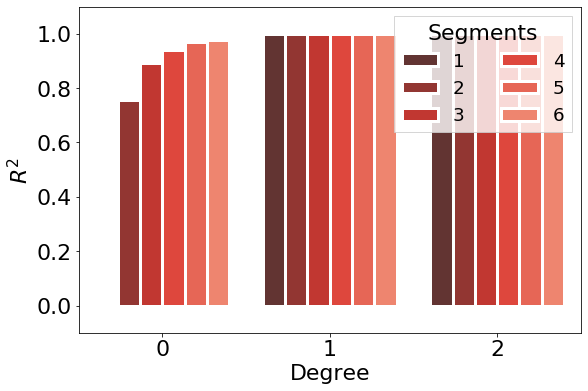

In [30]:
analyse_errors(df_err)